In [ ]:
#Install:
##1.HF's transformers library, 2.SP for t5,
##3.models' evaluation metric, 4.pdf to text string extraction library.
!pip install --upgrade transformers
!pip install --upgrade sentencepiece
!pip install bert_score
!pip install PyPDF2

In [51]:
#Importing libraries.
import PyPDF2
import sentencepiece as spm
import torch
import re
import matplotlib.pyplot as plt
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
from bert_score import score

# Notebook Aims


1.   **Use bart-large-cnn and T5 models for text summarization.**
Article 6 BloombergGPT_ A Large Language Model for Finance.
---
2.   **Create a very short but very informative and well-structured summaries.**
---
3.   **Test models' performance with pairwise cosine similarity function.**
---


In [23]:
#Instantiating models and tokenizers.
bart_summarizer = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn', cache_dir=None)
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
t5_summarizer = T5ForConditionalGeneration.from_pretrained('t5-large', cache_dir=None)
t5_tokenizer = T5Tokenizer.from_pretrained('t5-large')

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [24]:
#Move the models to GPU.
bart_summarizer = bart_summarizer.to('cuda')
t5_summarizer = t5_summarizer.to('cuda')

In [30]:
#Defining necessary functions.
#Part 1: Dealing with text inputs.

#Pre-processing: Clean the text before encoding.
def clean_text(text):
    """
    Input: through the pdf_extractor function.
    Ouptut: text without \xa0 or similar unwanted characters.
    """
    return re.sub(r'[\xa0]+', ' ', text)

#PDF extraction to text string.
def pdf_extractor(path):
    """
    Input: path to file.
    Output: text string.
    Functionality: this function extracts the pdf content into a text string format.
    """
    with open(path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        if pdf_reader.is_encrypted:
            pdf_reader.decrypt("")
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text()
    return clean_text(text)

#Text string chunks divider.
def text_chunker(text, model_tokenizer, max_tokens=350, overlapPercent=10):
    """
    Input: text output of pdf_extractor function.
    Output: chunks of tokens. I used a limit of 350 tokens as Bart-large-cnn limit
            is 1024 for encoder, but t5-large model limitations is 512 tokens for encoder and decoder together.
    Functionality: this function chunks the textual inputs.
    """
    tokens = model_tokenizer.tokenize(text)
    overlap_tokens = int(max_tokens * overlapPercent / 100)
    chunks = [tokens[i:i + max_tokens]
              for i in range(0, len(tokens),
                             max_tokens - overlap_tokens)]
    text_chunks = [model_tokenizer.decode(
        model_tokenizer.convert_tokens_to_ids(chunk),
        skip_special_tokens=True) for chunk in chunks]
    return text_chunks

In [27]:
#Defining necessary functions.
#Part 2:Encoding, summarization, and decoding the summaries.

#bart-large-cnn.Encoding limitation:1024.
def bart_summarize(text):
    """
    Input: text chunks.
    Output: summarized chunks inputs.
    Functionality:
                  -> sequential optimization (3 beams),
                  -> length penalty (0.6; Want to go with a bit shorter sentences),
                  -> summary output range (80-160 tokens per chunk).
    """
    inputs = bart_tokenizer.encode("summarize: " +
                                   text,
                                   return_tensors="pt",
                                   max_length=350,
                                   truncation=True).to('cuda')
    summary_ids = bart_summarizer.generate(inputs,
                                           max_length=160,
                                           min_length=80,
                                           num_beams=3,
                                           length_penalty=0.6,
                                           early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

#t5-large.Endodin+decoding limitaiton:512.
def t5_summarize(text):
    """
    Input: text chunks.
    Output: summarized chunks inputs.
    Functionality: -> sequential optimization (3 beams),
                   -> length penalty (0.6; Want to go with a bit shorter sentences),
                   -> summary output range (80-160 tokens per chunk).
    """
    inputs = t5_tokenizer.encode("summarize: " +
                                 text,
                                 return_tensors="pt",
                                 max_length=350,
                                 truncation=True).to('cuda')
    summary_ids = t5_summarizer.generate(inputs,
                                         max_length=160,
                                         min_length=80,
                                         num_beams=3,
                                         length_penalty=0.6,
                                         early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [28]:
#Defining necessary functions.
#Part 3: Recusion function over concatenated summary. The goal is to get iterate
##over the concatenated summary and get a summary of 210 tokens max.

#Recursive summarizer for bart-long-cnn.
def b_recursive_summarize(text, recursion_l=0):
    """
    Input: concatenated decoded summaries.
    Output: re-iterated summary (for contextual benefits) of max 210 tokens.
    Functionality: -> iterating over the summarized output,
                   -> gaining contextual benefits,
                   -> aiming at short and meaningful output of max 210 tokens.
    """
    recursion_level = recursion_l + 1
    print(f"Bart long recurs. level: {recursion_level}\n")
    tokens = bart_tokenizer.tokenize(text)
    expectedCountOfChunks = len(tokens)/210
    max_length=int(len(tokens)/expectedCountOfChunks)+2

    chunks = text_chunker(text,
                          bart_tokenizer,
                          max_tokens=350)
    print(f"Number of chunks: {len(chunks)}")

    summaries = []
    for i,chunk in enumerate(chunks,1):
      print(f"Chunk no.{i}:")
      print(chunk, "\n")
      summary = bart_summarize(chunk)
      print("Summary:", summary)
      summaries.append(summary)
      print("_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")
      torch.cuda.empty_cache()

    concatenated_summary = ' '.join(summaries)

    tokens = bart_tokenizer.tokenize(concatenated_summary)

    if len(tokens) > 210:
        print("Recursive")
        return b_recursive_summarize(concatenated_summary,
                                     recursion_l=recursion_level)
    else:
        final_summary = concatenated_summary
        if len(chunks) > 1:
            final_summary = bart_summarizer(concatenated_summary)
        return final_summary

#Recursive summarizer for t5-long.
def t5_recursive_summarize(text, recursion_l=0):
    """
    Input: concatenated decoded summaries.
    Output: re-iterated summary (for contextual benefits) of max 210 tokens.
    Functionality: -> iterating over the summarized output,
                   -> gaining contextual benefits,
                   -> aiming at short and meaningful output of max 210 tokens.
    """
    recursion_level = recursion_l + 1
    print(f"T5 recurs. level: {recursion_level}\n")
    tokens = t5_tokenizer.tokenize(text)
    expectedCountOfChunks = len(tokens)/210
    max_length=int(len(tokens)/expectedCountOfChunks)+2

    chunks = text_chunker(text,
                          t5_tokenizer,
                          max_tokens=350)
    print(f"Number of chunks: {len(chunks)}")

    summaries = []
    for i,chunk in enumerate(chunks,1):
      print(f"Chunk no.{i}:")
      print(chunk, "\n")
      summary = t5_summarize(chunk)
      print("Summary:", summary)
      summaries.append(summary)
      print("_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")
      torch.cuda.empty_cache()

    concatenated_summary = ' '.join(summaries)

    tokens = t5_tokenizer.tokenize(concatenated_summary)

    if len(tokens) > 210:
        print("Recursive")
        return t5_recursive_summarize(concatenated_summary,
                                     recursion_l=recursion_level)
    else:
        final_summary = concatenated_summary
        if len(chunks) > 1:
            final_summary = t5_summarizer(concatenated_summary)
        return final_summary

#Model performance evaluation: pairwise cosine similarity (Scalar Product of Vectors / Product of Norm Vectors in Euclidean norm).
# A*B / (sqrt(A**2) * sqrt(B**2)).
def evaluator(final_summary,text):
    """
    Input: the model generated summary and reference text (original).
    Output: pairwise cosine similarity in precision, recall, and harmonic mean (f1).
    Functionality: this function aims at evaluating the models' performances.
    """
    precision, recall, f1 = score(final_summary,text)
    return precision, recall, f1

In [32]:
#Extracting a PDF to text string.
text = pdf_extractor('/content/Article 6 BloombergGPT_ A Large Language Model for Finance.pdf')

#Bart recursive summarization.
bart_final_summary = b_recursive_summarize(text)

#T5 recursive summarization
t5_final_summary = t5_recursive_summarize(text)

Bart long recurs. level: 1

Number of chunks: 97
Chunk no.1:
BloombergGPT: A Large Language Model for Finance
Shijie Wu1,∗, Ozan ˙Irsoy1,∗, Steven Lu1,∗, Vadim Dabravolski1, Mark Dredze1,3,
Sebastian Gehrmann1, Prabhanjan Kambadur1, David Rosenberg2, Gideon Mann1
1Bloomberg, New York, NY USA
2Bloomberg, Toronto, ON Canada
3Computer Science, Johns Hopkins University, Baltimore, MD USA
Abstract
The use of NLP in the realm of ﬁnancial technology is broad and complex, with app lications
ranging from sentiment analysis and named entity recognition to questi on answering. Large
Language Models (LLMs) have been shown to be eﬀective on a variety of tasks ; however, no
LLM specialized for the ﬁnancial domain has been reported in literature. In this work, we
presentBloombergGPT, a 50 billion parameter language model that is trained on a wide
range of ﬁnancial data. We construct a 363 billion token dataset based on Bloombe rg’s
extensive data sources, perhaps the largest domain-speciﬁc dataset y 

In [33]:
#Printining out the final models' summaries.
print("Bart's summary:", bart_final_summary)
print("\n")
print("T5's summary:", t5_final_summary)

Bart's summary: BloombergGPT is a 50 billion parameter language model that is trained on a wide range of data. Financial Technology (FinTech) is a large and growing area with NLP technol ogies having an increasingly important role. Financial NLP tasks include sentiment analysis, news classiﬁcation, and question answering. No LLM has been tuned for or evaluated on tasks for the ﬁnancial domain.


T5's summary: the model outperforms existing models on financial tasks by significan t margins. it is based on a 50 billion-parameter language model with a 50 billion-parameter training set. goal for BloombergGPT was to be a best-class model for financial tasks. eBloomberg is interested in studying whether FinPile reduces proclivity of model to generate inappropriate content.


In [34]:
#Printing out the combined models' summary.
print("Combined summary:", bart_final_summary + " " + t5_final_summary)

Combined summary: BloombergGPT is a 50 billion parameter language model that is trained on a wide range of data. Financial Technology (FinTech) is a large and growing area with NLP technol ogies having an increasingly important role. Financial NLP tasks include sentiment analysis, news classiﬁcation, and question answering. No LLM has been tuned for or evaluated on tasks for the ﬁnancial domain. the model outperforms existing models on financial tasks by significan t margins. it is based on a 50 billion-parameter language model with a 50 billion-parameter training set. goal for BloombergGPT was to be a best-class model for financial tasks. eBloomberg is interested in studying whether FinPile reduces proclivity of model to generate inappropriate content.


In [63]:
#Evaluate the models' performance.
#Using the Bart score which is a function of the scalar vector and the vectors' Euclidean norm.
##AB/(||A||*||B||) or ((a1b1)+(a2b2)...+(anbn)) / (sqrt(a1**2+a2**2...+an**2) * sqrt(b1**2+b2**2...+bn**2)).
combined_summary = bart_final_summary + " " + t5_final_summary

reference_texts = [text,text,text]
candidate_summaries = [bart_final_summary, t5_final_summary, combined_summary]

P, R, F1 = score(candidate_summaries, reference_texts, lang="en", verbose=True)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.22 seconds, 2.46 sentences/sec


In [64]:
#Models' performance.
for i, (p, r, f1) in enumerate(zip(P.tolist(), R.tolist(), F1.tolist())):
    print(f"Summary {i+1} -- P: {p:.4f}, R: {r:.4f}, F1: {f1:.4f}")

Summary 1 -- P: 0.8799, R: 0.7593, F1: 0.8152
Summary 2 -- P: 0.8537, R: 0.7339, F1: 0.7893
Summary 3 -- P: 0.8701, R: 0.7710, F1: 0.8175


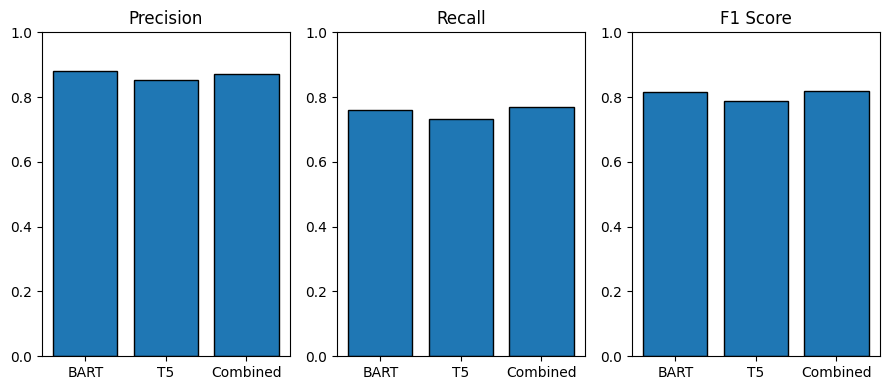

In [65]:
#Visualizing models' performance.
P = P.tolist()
R = R.tolist()
F1 = F1.tolist()

summaries = ['BART', 'T5', 'Combined']

x = range(len(summaries))

plt.figure(figsize=(9, 4))
plt.subplot(1, 3, 1)
plt.bar(x, P, edgecolor='black')
plt.xticks(x, summaries)
plt.title('Precision')
plt.ylim(0, 1)
plt.subplot(1, 3, 2)
plt.bar(x, R, edgecolor='black')
plt.xticks(x, summaries)
plt.title('Recall')
plt.ylim(0, 1)
plt.subplot(1, 3, 3)
plt.bar(x, F1, edgecolor='black')
plt.xticks(x, summaries)
plt.title('F1 Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()